# Fit model of auxotrophic communities to data from range expansions experiments

In all cases we fit increase in Pro uptake, and in Pro and Trp leakage.
In addition we try 4 different procedures:

1. no other fits
2. fit density to community A
3. fit density and trp and pro leakage to community A
4. fit trp and pro leakage to community A

The first two fail to converge for fitting increase in Pro and Trp leakage.

Note: equation numbers refer to main text of van Vliet et al Plos Comp Bio 2022.

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from community import community
matplotlib.rc("figure", figsize=(10,5))


## Load Data and set experimentally measured parameters

In [4]:
#init dictionary to store fit parameters
fit_pars_0 = {} # parameters for the fit, community A not fitted
fit_pars_1 = {} # parameters for the fit, community A fitted for density
fit_pars_2 = {} # parameters for the fit, community A fitted for density and leakage
fit_pars_3 = {} # parameters for the fit, community A fitted for leakage 

#init dictionary width measured growth rates
growth_rates = {'WT':0.27, 
                'dP':0.24,
                'dT':0.24,
                'dP_trpOP':0.29, # tryptophan overproduction mutant
                'dT_proOP':0.31, # proline overproduction mutant
                'dP_proUp':0.049, # proline uptake mutant
                'dP_proUp_trpOP':0.048 # proline uptake + tryptophan overproduction  mutant
                } 

#load data
df_all = pd.read_csv('community_data.csv')

#average over technical replicates
df_all['Identifier'] = df_all.apply(lambda row: f"{row['Condition']}-{row['Rep']}", axis=1)
df = df_all.groupby('Identifier').agg({'Width': 'mean', 'dT_patch': 'mean', 'dP_patch': 'mean', 'Ratio': 'mean', 'Condition': 'first', 'Rep': 'first'}).reset_index()

#add relative patch width
df['rel_range'] = df['dP_patch']/df['dT_patch']

#average over biological replicates
df_mean = df.groupby('Condition')[['Ratio', 'Width', 'dT_patch', 'dP_patch', 'rel_range']].mean().reset_index()
df_mean.head(n=9)

,Condition,Ratio,Width,dT_patch,dP_patch,rel_range
0,A,0.259426,99.855962,9.642489,38.759026,4.066068
1,B,0.419124,165.937762,34.599521,22.536955,0.940167
2,C,0.590971,-0.490552,8.281197,19.247165,2.396698
3,D,0.625701,298.223025,9.188725,5.445170,0.656216
4,E,0.192119,803.814899,119.566868,491.048497,4.065417
5,F,0.387379,854.308375,134.352018,147.889317,1.109466
6,G,0.409993,846.470840,113.478865,189.711251,1.658255
7,H,0.403510,873.030570,133.066353,174.321082,1.297801
8,WT,0.542899,1083.484242,192.774160,782.705439,3.619530


### Calculate coefficient of variation between biological replicates

In [5]:
df_cv = df.groupby('Condition')[['Width', 'dT_patch', 'dP_patch', 'Ratio', 'rel_range']].std().reset_index() 
df_cv = df_cv[['Ratio','Width', 'dT_patch', 'dP_patch', 'rel_range']] / df_mean[['Ratio', 'Width', 'dT_patch', 'dP_patch','rel_range']]
df_cv.head(n=9)

,Ratio,Width,dT_patch,dP_patch,rel_range
0,0.077417,0.349804,0.115030,0.660145,0.663693
1,0.092874,0.409066,1.786732,1.361507,0.508941
2,0.037607,-45.550376,0.143672,0.962493,0.942641
3,0.023122,0.177079,0.336655,0.114867,0.380720
4,0.306925,0.055162,0.166711,1.078961,0.984688
5,0.108922,0.051664,0.190307,0.222851,0.198265
6,0.215813,0.068042,0.165026,0.492915,0.465320
7,0.189878,0.059639,0.107861,0.539521,0.465596
8,0.108644,0.071996,0.348009,1.031594,0.803884


## Define functions

In [6]:
def plot_growth_profile(community):
    ''' Plot growth profiles of the community
    
    Parameters:
    community: community object
    
    Returns:
    fig: figure object
    
    '''

    #set colors
    yellow = np.array([246,219,147])/255
    blue = np.array([42,86,152])/255
    
    #calculate growth profiles
    x_vec = np.linspace(0,60,1000)
    community.calc_growth_profiles(x_vec)
    #community.calc_growth_profiles_sectors()
    
    #normalize to WT growth rate
    muWT = community.mu0 * 3600
    
    #plot growth profiles
    fig,ax = plt.subplots(1,1,figsize=(5,5))
    ax.plot(community.x_T, community.mu_profile_T/muWT, color=yellow, label='dT')
    ax.plot(community.x_P, community.mu_profile_P/muWT, color=blue, label='dP')
    
    # ax.plot(community.x_sector_T, community.mu_profile_sector_T/muWT, color=yellow, label='dT sect', linestyle='--')
    # ax.plot(community.x_sector_P, community.mu_profile_sector_P/muWT, color=blue, label='dP sect', linestyle='--')    
    
    ax.set_xlabel('Position (um)')
    ax.set_ylabel('Growth rate relative to WT')
    ax.set_ylim(0,1)
    
    #add reference lines
    plt.axvline(x=0, color='k', linestyle='-')
    plt.axvline(x=community.rangeP, color=blue, linestyle=':')
    plt.axvline(x=-community.rangeT, color=yellow, linestyle=':')

    return fig

def report_data(df, condition):
    df_sum = df[df['Condition']==condition]
    
    rel_growth = df_sum["Width"].mean()  / df.loc[df['Condition']=='WT']['Width'].mean() 
    sector_ratio = np.mean(df_sum['dP_patch'] / df_sum['dT_patch'])
    
    print(f"Experiments: C{condition:s}: f(dT) = {df_sum['Ratio'].mean() :.2f}, rel. growth = {rel_growth:.2f}, sectors dP = {df_sum['dP_patch'].mean() :.2f}um, sectors dT = {df_sum['dT_patch'].mean() :.2f}um, sector ratio = {sector_ratio:.2f}")
    return None

def fit_par(x, L2_norm):
    ''' Find x value of minimum L2 norm
    
    Parameters:
    x: x data
    L2_norm: L2 norm
    
    Returns:
    x value of minimum L2 norm
    '''
    min_idx = np.argmin(L2_norm)
    return x[min_idx]

def fit_1D(x, y_data, y_model):
    ''' Fit 1D data'''
    L2_norm = (y_model - y_data)**2
    min_idx = np.argmin(L2_norm)
    
    fitted_x = x[min_idx]    
    fig, axs = plt.subplots(1,1,figsize=(5,3))
    
    axs.plot(x, y_model, label='model')
    axs.plot(x, np.ones_like(x) * y_data.mean(), label='data')
    axs.axvline(x=fitted_x, color='k', linestyle='--')
    
    if min_idx == x.size-1:
        fitted_x = np.nan
    
    return (fitted_x, min_idx)     

def fit_2D(x, y, z1, z2, z1_data, z2_data, log_scale=False):
      
    delta1 = (z1 - z1_data)/z1_data
    delta2 = (z2 - z2_data)/z2_data
    L2_norm_comb = np.log10(delta1**2 + delta2**2)

    idx_y, idx_x = np.unravel_index(np.argmin(L2_norm_comb), L2_norm_comb.shape)
    xfit = x[idx_x]
    yfit = y[idx_y]

    fig,axs = plt.subplots(1,3,figsize=(15,5))

    im0 = axs[0].imshow(z1, extent=[x.min(), x.max(), y.min(), y.max()], origin='lower',aspect='auto')
    fig.colorbar(im0, ax=axs[0])
    axs[0].contour(x, y, z1, levels=[z1_data.mean()], colors='r')
    axs[0].contour(x, y, z2, levels=[z2_data.mean()], colors='m')
    axs[0].axvline(x=xfit, color='k', linestyle='--')
    axs[0].axhline(y=yfit, color='k', linestyle='--')
    
    #set axis to log scale
    if log_scale:
        axs[0].set_xscale('log')
        axs[0].set_yscale('log')

    im1 = axs[1].imshow(z2, extent=[x.min(), x.max(), y.min(), y.max()], origin='lower',aspect='auto')
    fig.colorbar(im1, ax=axs[1])
    axs[1].contour(x, y, z1, levels=[z1_data.mean()], colors='m')
    axs[1].contour(x, y, z2, levels=[z2_data.mean()], colors='r')
    axs[1].axvline(x=xfit, color='k', linestyle='--')
    axs[1].axhline(y=yfit, color='k', linestyle='--')
    
    #set axis to log scale
    if log_scale:
        axs[1].set_xscale('log')
        axs[1].set_yscale('log')

    im2 = axs[2].imshow(L2_norm_comb, origin='lower', extent=[x.min(), x.max(), y.min(), y.max()], aspect='auto')
    fig.colorbar(im2, ax=axs[2])
    axs[2].axvline(x=xfit, color='k', linestyle='--')
    axs[2].axhline(y=yfit, color='k', linestyle='--')
    
    #set axis to log scale
    if log_scale:
        axs[2].set_xscale('log')
        axs[2].set_yscale('log')

    return (xfit, yfit)

---
## Fit community A

We optionally fit density and pro and trp leakage to community A (dP+dT)

We first check the predictions on community A without further fitting

### No fitting

In [7]:
community_A = community(mu_WT=growth_rates['WT'], mu_dT=growth_rates['dT'], mu_dP=growth_rates['dP'])
print('Model predictions for community A, no fit:')
community_A.report_properties()
print('\nExperimental measurements of community A:')
report_data(df, 'A')

Model predictions for community A, no fit:
Frequency dT = 0.28
Clustering dT = 0.90, Clustering dP = 0.99
Growth relative to WT = 0.20
Growth defect spatial community = 0.94
mu_max dP = 0.20, mu_max dT = 0.08
range dP = 13.60um, range dT = 2.62um, range dP/dT = 5.18

Experimental measurements of community A:
Experiments: CA: f(dT) = 0.26, rel. growth = 0.09, sectors dP = 38.76um, sectors dT = 9.64um, sector ratio = 4.07



### Fit density on community A
We fit density based on sector size from WT community, we assume that the correlation length is similar to interaction length. 

Model predictions for community A, fit density:
Frequency dT = 0.29
Clustering dT = 0.99, Clustering dP = 1.00
Growth relative to WT = 0.21
Growth defect spatial community = 0.99
mu_max dP = 0.20, mu_max dT = 0.08
range dP = 42.98um, range dT = 8.29um, range dP/dT = 5.18

Experimental measurements of community A:
Experiments: CA: f(dT) = 0.26, rel. growth = 0.09, sectors dP = 38.76um, sectors dT = 9.64um, sector ratio = 4.07


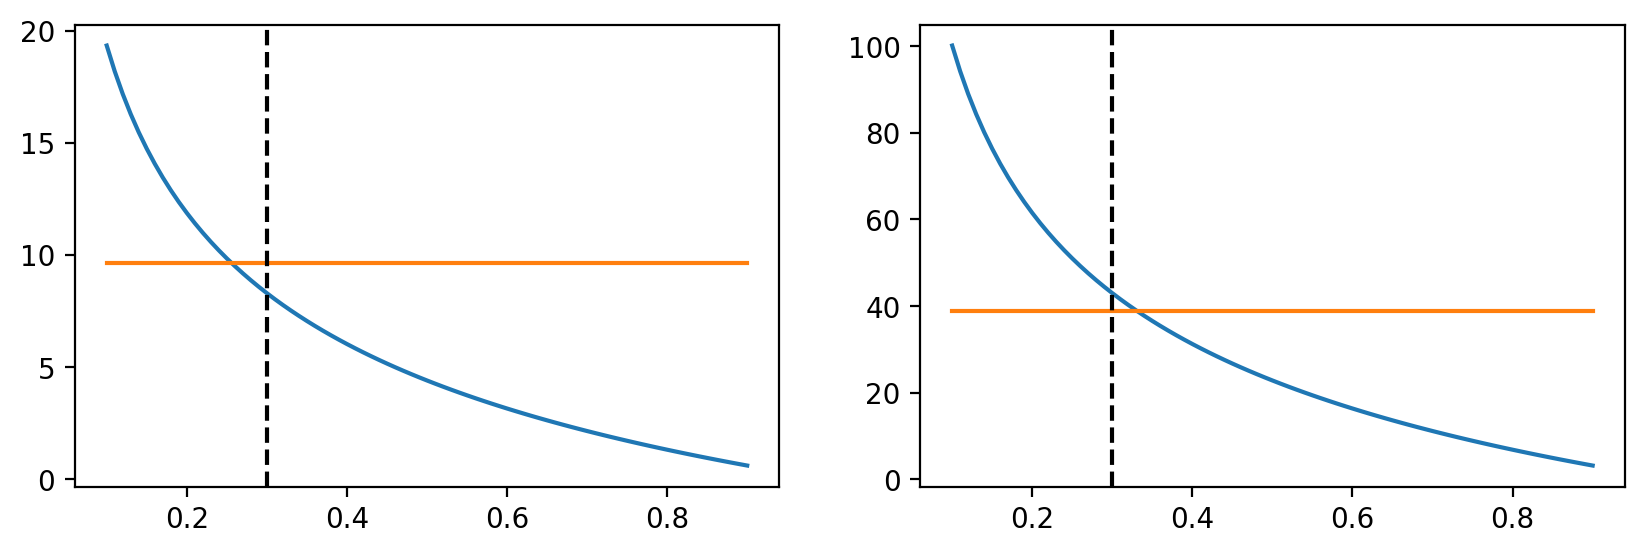

In [8]:
#set baseline community
rho_vec = np.linspace(0.1,0.9,81)
community_A1 = community(rho=rho_vec, mu_WT=growth_rates['WT'], mu_dT=growth_rates['dT'], mu_dP=growth_rates['dP'])
def_com = community()

#calculate average sector width
est_rangeT = df_mean.loc[df_mean['Condition']=='A']['dT_patch'].values[0]
est_rangeP = df_mean.loc[df_mean['Condition']=='A']['dP_patch'].values[0]

#calcualte combined normalized error
L2_dP = (community_A1.rangeT - est_rangeT)/est_rangeT
L2_dT = (community_A1.rangeP - est_rangeP)/est_rangeP
L2_norm = L2_dP**2 + L2_dT**2
rho_opt = fit_par(rho_vec, L2_norm)

fit_pars_0['rho'] = def_com.rho
fit_pars_1['rho'] = rho_opt
fit_pars_2['rho'] = rho_opt
fit_pars_3['rho'] = def_com.rho

#plot fit results
fig, axs = plt.subplots(1,2,figsize=(10,3))
axs[0].plot(rho_vec, community_A1.rangeT, label='model')
axs[0].plot(rho_vec, np.ones_like(rho_vec) * np.mean(est_rangeT), label='data')
axs[0].axvline(x=rho_opt, color='k', linestyle='--')

axs[1].plot(rho_vec, community_A1.rangeP, label='model')
axs[1].plot(rho_vec, np.ones_like(rho_vec) * np.mean(est_rangeP), label='data')
axs[1].axvline(x=rho_opt, color='k', linestyle='--')

#plot community results
community_A1_fit = community(rho=fit_pars_1['rho'], mu_WT=growth_rates['WT'], mu_dT=growth_rates['dT'], mu_dP=growth_rates['dP'])
print('Model predictions for community A, fit density:')
community_A1_fit.report_properties()
print('\nExperimental measurements of community A:')
report_data(df, 'A')

### Fit leakage rates  on community A

w/ rho: Pro leakage = 9.2e-07 (original = 1.59e-05), Trp leakage = 7.9e-08 (original = 6.04e-07)
no rho: Pro leakage = 9.59e-07 (original = 1.59e-05), Trp leakage = 9.53e-08 (original = 6.04e-07)

Model predictions for community A, fit density and  leakage:
Frequency dT = 0.26
Clustering dT = 0.98, Clustering dP = 1.00
Growth relative to WT = 0.09
Growth defect spatial community = 0.99
mu_max dP = 0.10, mu_max dT = 0.03
range dP = 33.54um, range dT = 7.85um, range dP/dT = 4.27

Model predictions for community A, fit leakage:
Frequency dT = 0.26
Clustering dT = 0.89, Clustering dP = 0.99
Growth relative to WT = 0.09
Growth defect spatial community = 0.93
mu_max dP = 0.10, mu_max dT = 0.04
range dP = 10.64um, range dT = 2.49um, range dP/dT = 4.27

Experimental measurements of community A:
Experiments: CA: f(dT) = 0.26, rel. growth = 0.09, sectors dP = 38.76um, sectors dT = 9.64um, sector ratio = 4.07


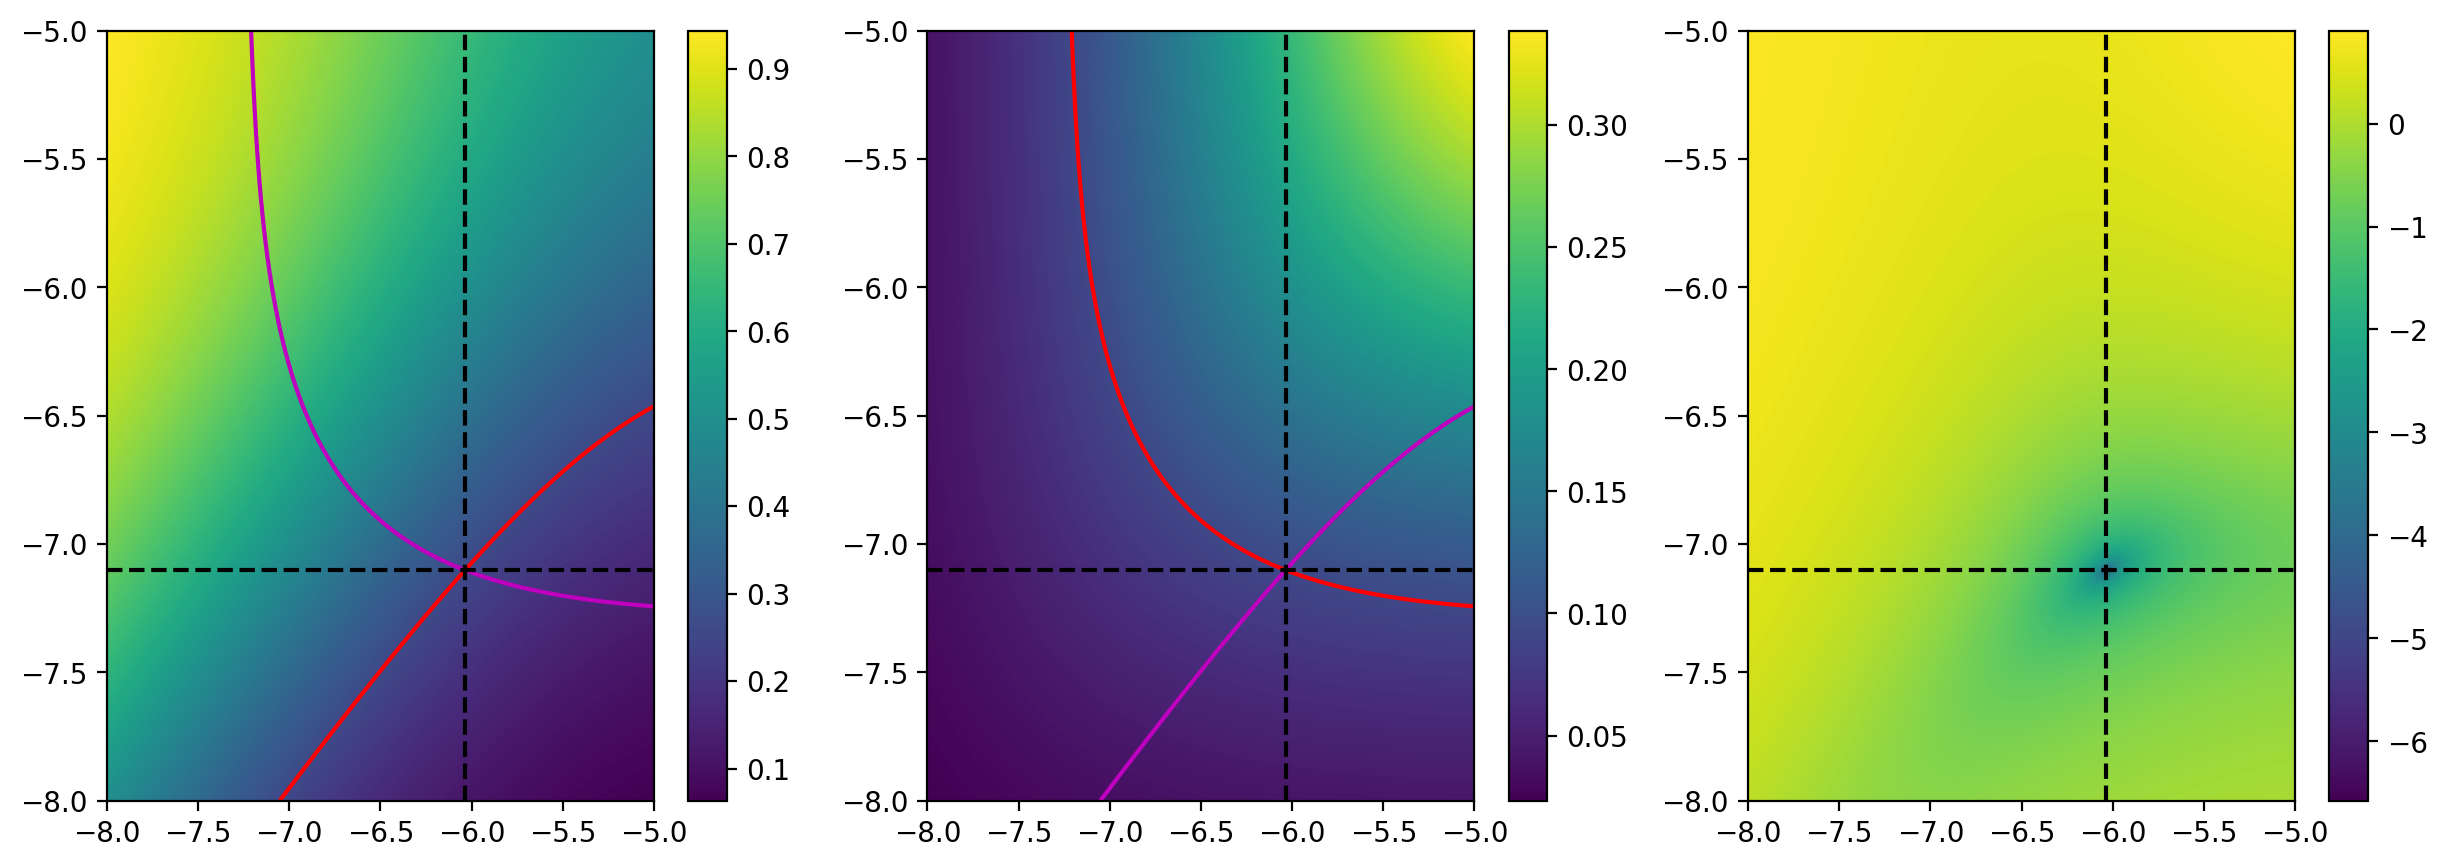

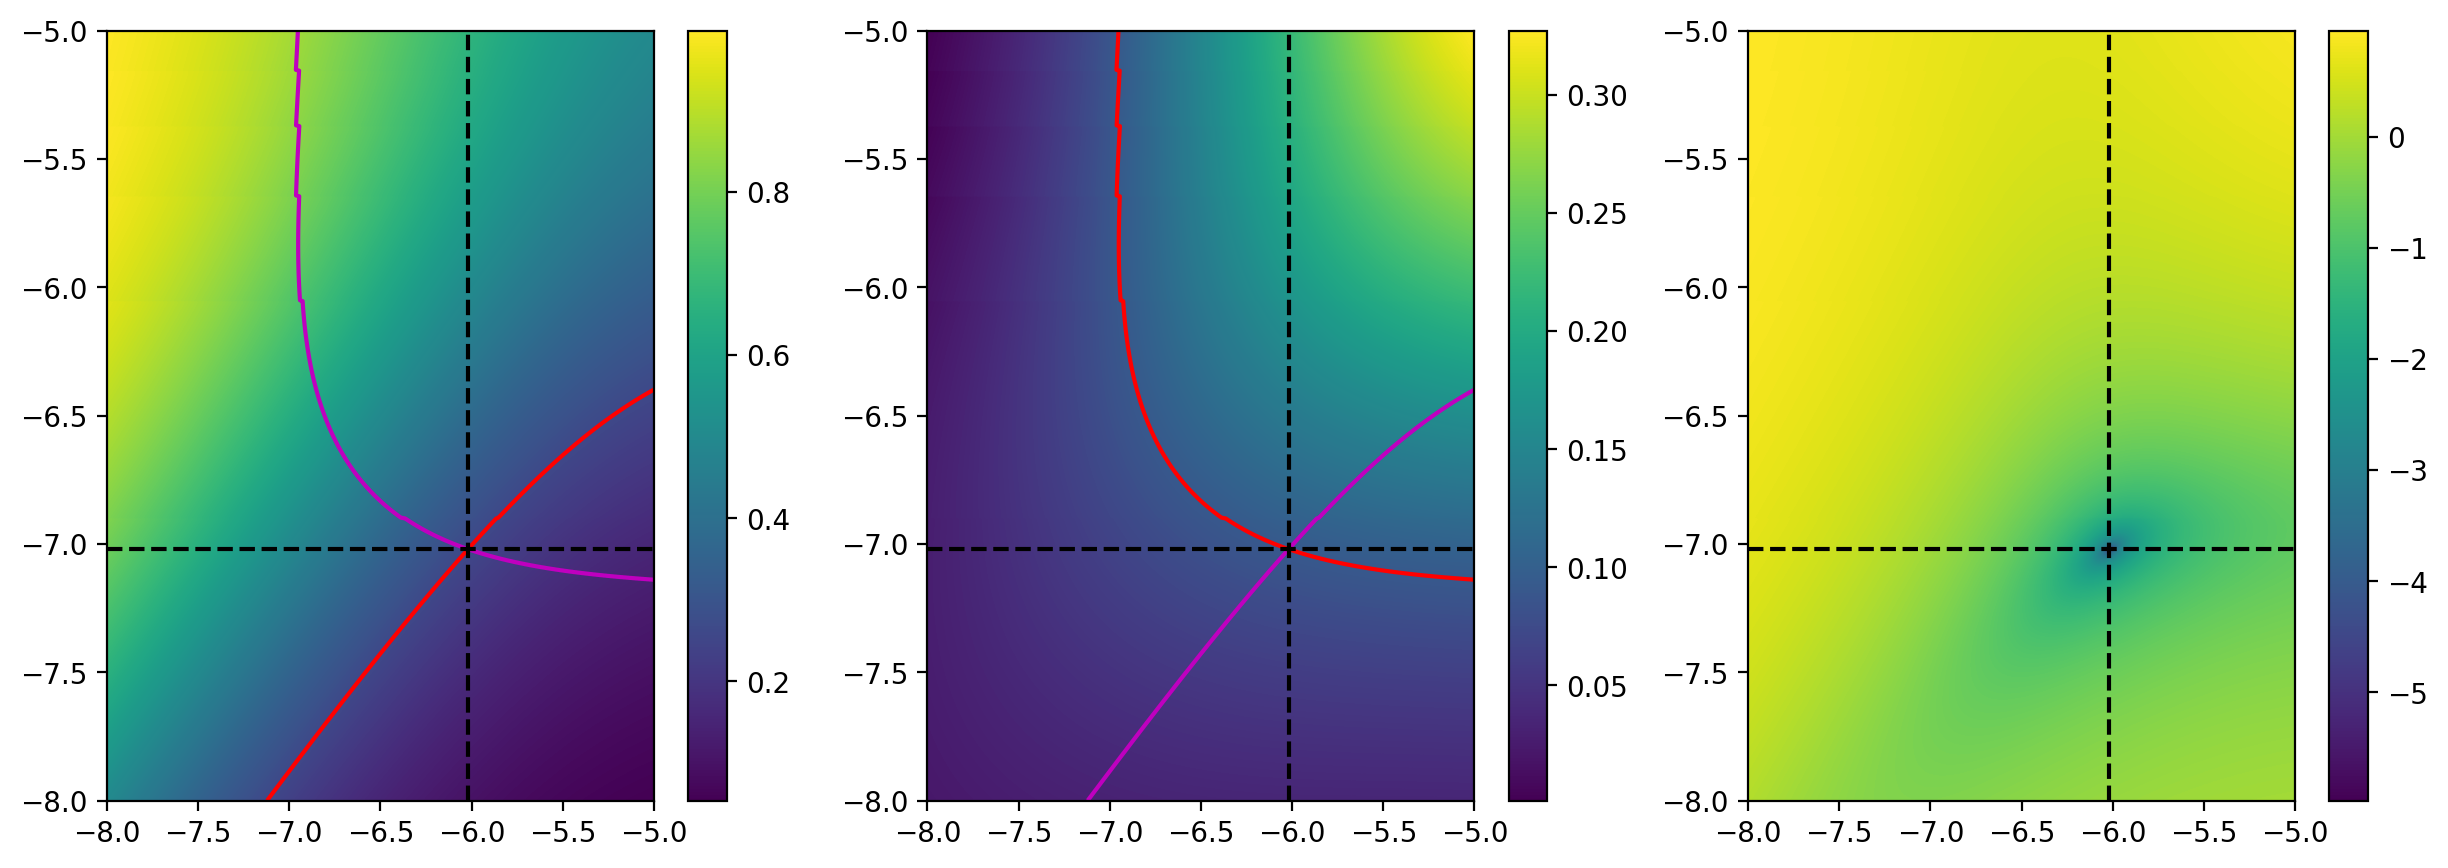

In [9]:
lPro = np.linspace(-8,-5,1000)
lTrp = np.linspace(-8,-5,1000)

def_com = community()

xmat, ymat = np.meshgrid(lPro, lTrp)

eq_data = df_mean.loc[df_mean['Condition']=='A']['Ratio'].values[0] 
growth_data = df_mean.loc[df_mean['Condition']=='A']['Width'].values[0] / df_mean.loc[df_mean['Condition']=='WT']['Width'].values[0] 

community_A2 = community(lPro=10**xmat, lTrp=10**ymat, 
                         mu_WT=growth_rates['WT'], 
                         mu_dT=growth_rates['dT'], 
                         mu_dP=growth_rates['dP'], 
                         rho=fit_pars_2['rho'])

community_A3 = community(lPro=10**xmat, lTrp=10**ymat, 
                         mu_WT=growth_rates['WT'], 
                         mu_dT=growth_rates['dT'], 
                         mu_dP=growth_rates['dP'], 
                         rho=fit_pars_3['rho'])

xfit2, yfit2 = fit_2D(lPro, lTrp, community_A2.eq, community_A2.rel_growth_wt, eq_data, growth_data)
xfit3, yfit3 = fit_2D(lPro, lTrp, community_A3.eq, community_A3.rel_growth_wt, eq_data, growth_data)

lPro_fit2 = 10**xfit2
lTrp_fit2 = 10**yfit2

lPro_fit3 = 10**xfit3
lTrp_fit3 = 10**yfit3

fit_pars_0['lPro'] = def_com.lPro
fit_pars_1['lPro'] = def_com.lPro
fit_pars_2['lPro'] = lPro_fit2
fit_pars_3['lPro'] = lPro_fit3

fit_pars_0['lTrp'] = def_com.lTrp
fit_pars_1['lTrp'] = def_com.lTrp
fit_pars_2['lTrp'] = lTrp_fit2
fit_pars_3['lTrp'] = lTrp_fit3

print(f"w/ rho: Pro leakage = {lPro_fit2:.3g} (original = {def_com.lPro:.3g}), Trp leakage = {lTrp_fit2:.3g} (original = {def_com.lTrp:.3g})")
print(f"no rho: Pro leakage = {lPro_fit3:.3g} (original = {def_com.lPro:.3g}), Trp leakage = {lTrp_fit3:.3g} (original = {def_com.lTrp:.3g})")

community_A2_fit = community(rho=fit_pars_2['rho'], 
                             mu_WT=growth_rates['WT'], 
                             mu_dT=growth_rates['dT'], 
                             mu_dP=growth_rates['dP'],
                             lPro=fit_pars_2['lPro'], 
                             lTrp=fit_pars_2['lTrp'])

community_A3_fit = community(rho=fit_pars_3['rho'], 
                             mu_WT=growth_rates['WT'], 
                             mu_dT=growth_rates['dT'], 
                             mu_dP=growth_rates['dP'],
                             lPro=fit_pars_3['lPro'], 
                             lTrp=fit_pars_3['lTrp'])

print('\nModel predictions for community A, fit density and  leakage:')
community_A2_fit.report_properties()

print('\nModel predictions for community A, fit leakage:')
community_A3_fit.report_properties()

print('\nExperimental measurements of community A:')
report_data(df, 'A')

---
## Characterize putP using community B

### fit change in sector size of dP between communities A (dP+dT) and B (dP-pEP17-putP + dT)

c_up_P = 9.80 (no fit) || 9.80 (rho fit) || 6.10 (rho + leakage fit) || 6.10 (leakage fit)
eqFr-B = 0.65 (no fit) || 0.63 (rho fit) || 0.44 (rho + leakage fit) || 0.45 (leakage fit)
sec_dP = 7.90 (no fit) || 24.96 (rho fit) || 19.46 (rho + leakage fit) || 6.20 (leakage fit)
sec_PT = 3.01 (no fit) || 3.01 (rho fit) || 2.48 (rho + leakage fit) || 2.49 (leakage fit)
eqFr-A = 0.28 (no fit) || 0.29 (rho fit) || 0.26 (rho + leakage fit) || 0.26 (leakage fit)
Experiments: CB: f(dT) = 0.42, rel. growth = 0.15, sectors dP = 22.54um, sectors dT = 34.60um, sector ratio = 0.94


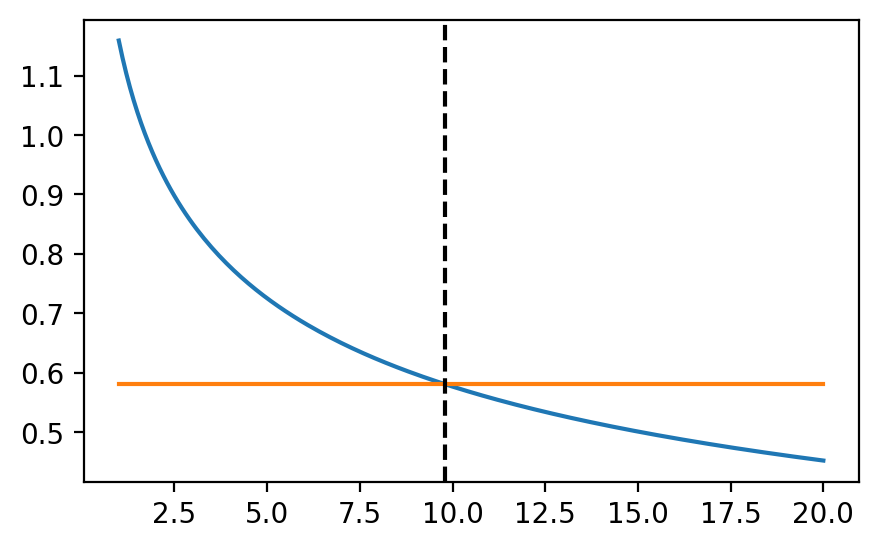

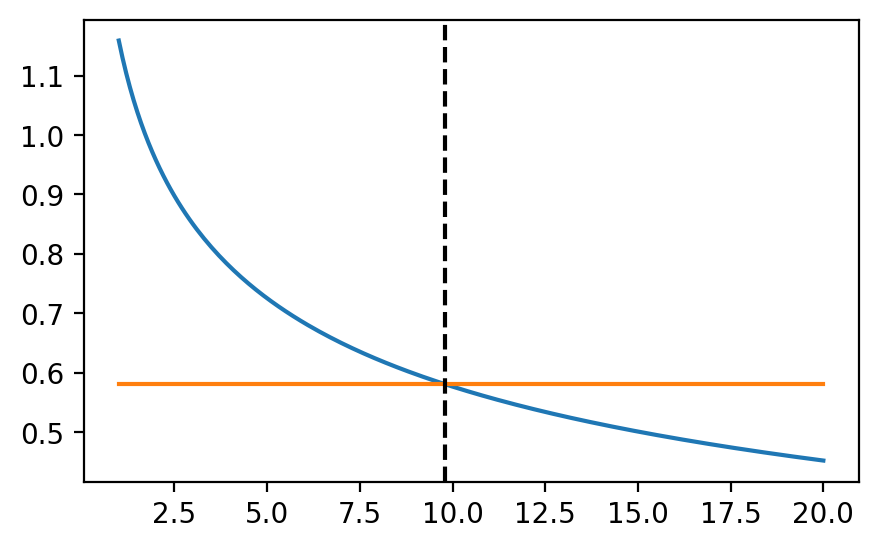

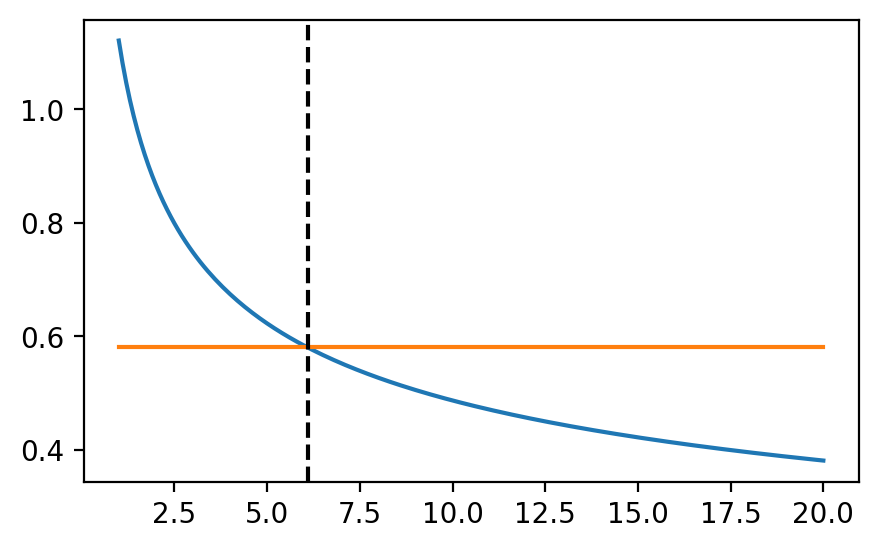

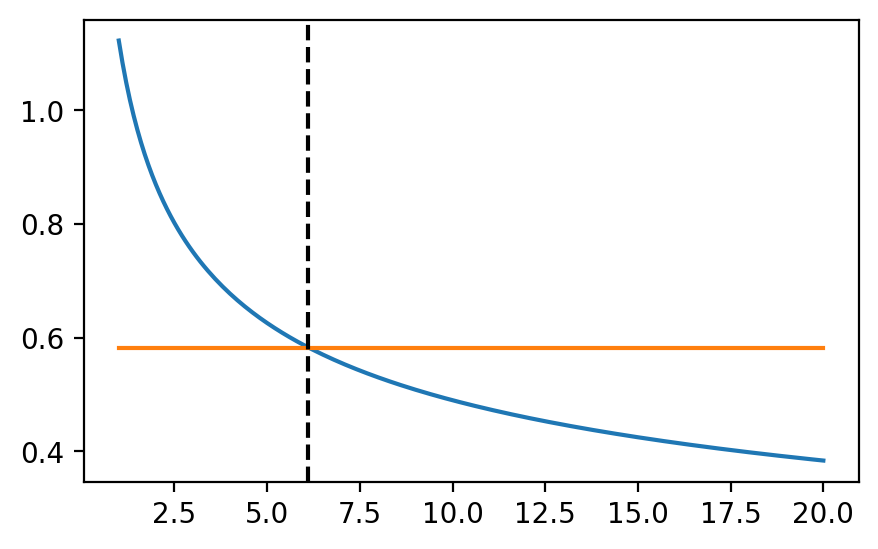

In [10]:
change_dP_sector_data = df_mean.loc[df_mean['Condition']=='B']['dP_patch'].values[0] / df_mean.loc[df_mean['Condition']=='A']['dP_patch'].values[0] 

c_up_P = np.arange(1,20.1,0.1)
#option 0: no other fits
community_A0 = community(rho=fit_pars_0['rho'], lPro=fit_pars_0['lPro'], lTrp=fit_pars_0['lTrp'], mu_WT=growth_rates['WT'], mu_dT=growth_rates['dT'], mu_dP=growth_rates['dP'])
community_B0 = community(rho=fit_pars_0['rho'], lPro=fit_pars_0['lPro'], lTrp=fit_pars_0['lTrp'], mu_WT=growth_rates['WT'], mu_dT=growth_rates['dT'], mu_dP=growth_rates['dP_proUp'], c_up_P=c_up_P)
#option 1: fit rho
community_A1 = community(rho=fit_pars_1['rho'], lPro=fit_pars_1['lPro'], lTrp=fit_pars_1['lTrp'], mu_WT=growth_rates['WT'], mu_dT=growth_rates['dT'], mu_dP=growth_rates['dP'])
community_B1 = community(rho=fit_pars_1['rho'], lPro=fit_pars_1['lPro'], lTrp=fit_pars_1['lTrp'], mu_WT=growth_rates['WT'], mu_dT=growth_rates['dT'], mu_dP=growth_rates['dP_proUp'], c_up_P=c_up_P)
#option 2: fit rho and leakage
community_A2 = community(rho=fit_pars_2['rho'], lPro=fit_pars_2['lPro'], lTrp=fit_pars_2['lTrp'], mu_WT=growth_rates['WT'], mu_dT=growth_rates['dT'], mu_dP=growth_rates['dP'])
community_B2 = community(rho=fit_pars_2['rho'], lPro=fit_pars_2['lPro'], lTrp=fit_pars_2['lTrp'], mu_WT=growth_rates['WT'], mu_dT=growth_rates['dT'], mu_dP=growth_rates['dP_proUp'], c_up_P=c_up_P)
#option 3: fit leakage
community_A3 = community(rho=fit_pars_3['rho'], lPro=fit_pars_3['lPro'], lTrp=fit_pars_3['lTrp'], mu_WT=growth_rates['WT'], mu_dT=growth_rates['dT'], mu_dP=growth_rates['dP'])
community_B3 = community(rho=fit_pars_3['rho'], lPro=fit_pars_3['lPro'], lTrp=fit_pars_3['lTrp'], mu_WT=growth_rates['WT'], mu_dT=growth_rates['dT'], mu_dP=growth_rates['dP_proUp'], c_up_P=c_up_P)

y0 = community_B0.rangeP / community_A0.rangeP
y1 = community_B1.rangeP / community_A1.rangeP
y2 = community_B2.rangeP / community_A2.rangeP
y3 = community_B3.rangeP / community_A3.rangeP

c_up0, idx0 = fit_1D(c_up_P, change_dP_sector_data, y0)
c_up1, idx1 = fit_1D(c_up_P, change_dP_sector_data, y1)
c_up2, idx2 = fit_1D(c_up_P, change_dP_sector_data, y2)
c_up3, idx3 = fit_1D(c_up_P, change_dP_sector_data, y3)

print(f"c_up_P = {c_up0:.2f} (no fit) || {c_up1:.2f} (rho fit) || {c_up2:.2f} (rho + leakage fit) || {c_up3:.2f} (leakage fit)")
print(f"eqFr-B = {community_B0.eq[idx0]:.2f} (no fit) || {community_B1.eq[idx1]:.2f} (rho fit) || {community_B2.eq[idx2]:.2f} (rho + leakage fit) || {community_B3.eq[idx3]:.2f} (leakage fit)")
print(f"sec_dP = {community_B0.rangeP[idx0]:.2f} (no fit) || {community_B1.rangeP[idx1]:.2f} (rho fit) || {community_B2.rangeP[idx2]:.2f} (rho + leakage fit) || {community_B3.rangeP[idx3]:.2f} (leakage fit)")
print(f"sec_PT = {community_B0.rangeP[idx0]/community_B0.rangeT:.2f} (no fit) || {community_B1.rangeP[idx1]/community_B1.rangeT:.2f} (rho fit) || {community_B2.rangeP[idx2]/community_B2.rangeT:.2f} (rho + leakage fit) || {community_B3.rangeP[idx3]/community_B3.rangeT:.2f} (leakage fit)")
print(f"eqFr-A = {community_A0.eq:.2f} (no fit) || {community_A1.eq:.2f} (rho fit) || {community_A2.eq:.2f} (rho + leakage fit) || {community_A3.eq:.2f} (leakage fit)")

report_data(df, 'B')

fit_pars_0['c_up_P'] = c_up0 
fit_pars_1['c_up_P'] = c_up1 
fit_pars_2['c_up_P'] = c_up2 
fit_pars_3['c_up_P'] = c_up3 

### IGNORED: Fit change in ratio of dP to dT between communities A (dP+dT) and B (dP-pEP17-putP + dT)

This fit procedure gives very high values

c_up_P = 217.30 (no fit) || 217.30 (rho fit) || 92.30 (rho + leakage fit) || 93.70 (leakage fit)
eqFrac = 0.65 (no fit) || 0.63 (rho fit) || 0.41 (rho + leakage fit) || 0.42 (leakage fit)
sec_dP = 2.47 (no fit) || 7.80 (rho fit) || 7.38 (rho + leakage fit) || 2.34 (leakage fit)
sec_PT = 0.94 (no fit) || 0.94 (rho fit) || 0.94 (rho + leakage fit) || 0.94 (leakage fit)
Experiments: CB: f(dT) = 0.42, rel. growth = 0.15, sectors dP = 22.54um, sectors dT = 34.60um, sector ratio = 0.94


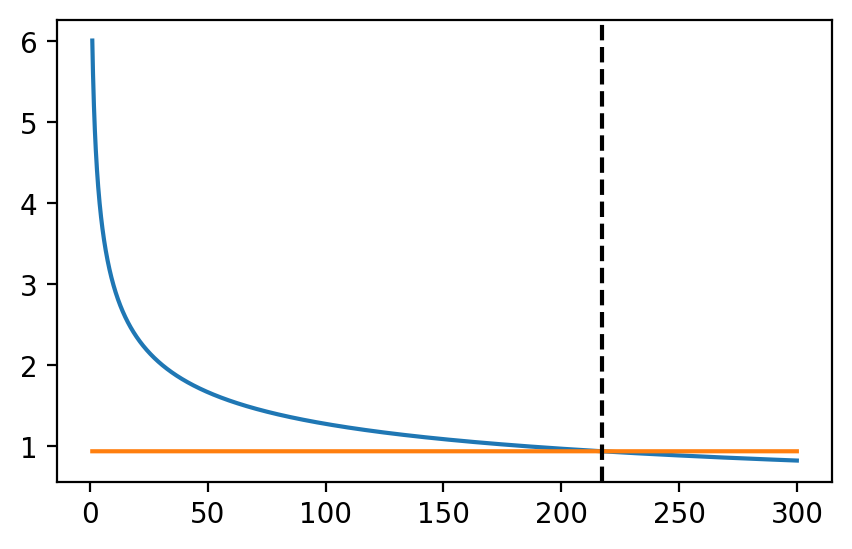

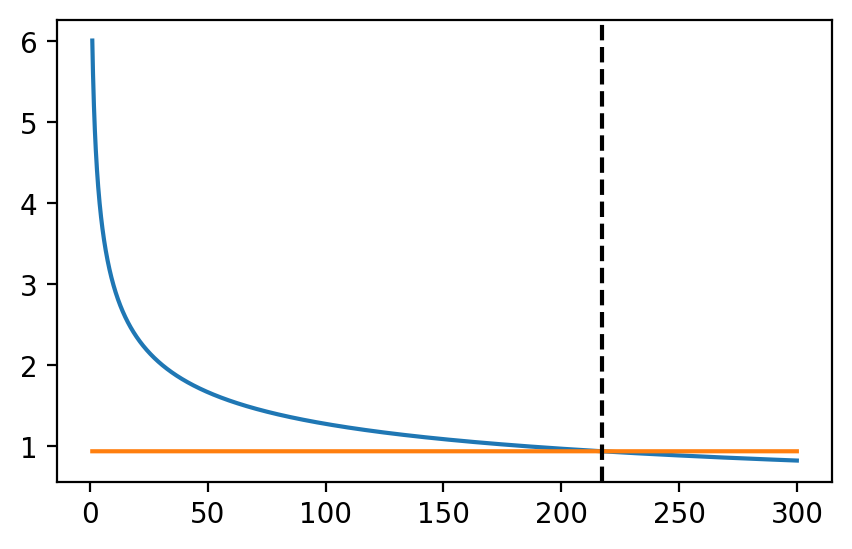

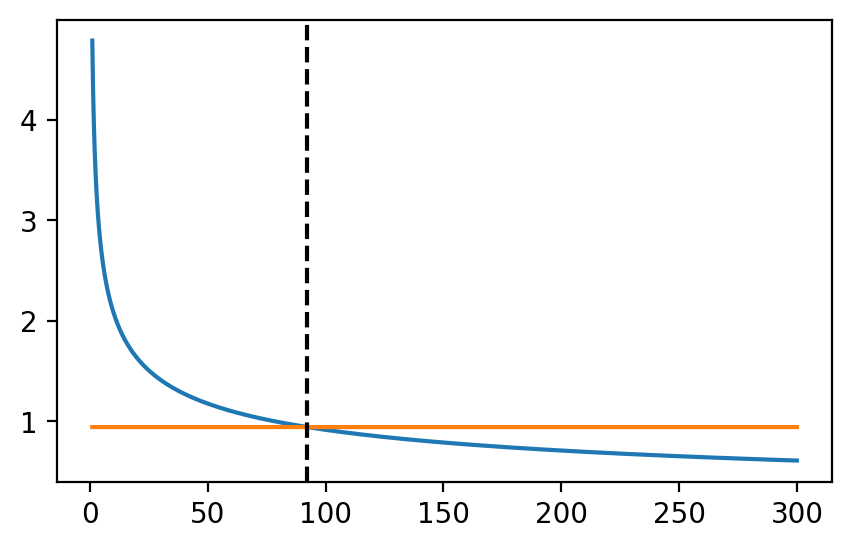

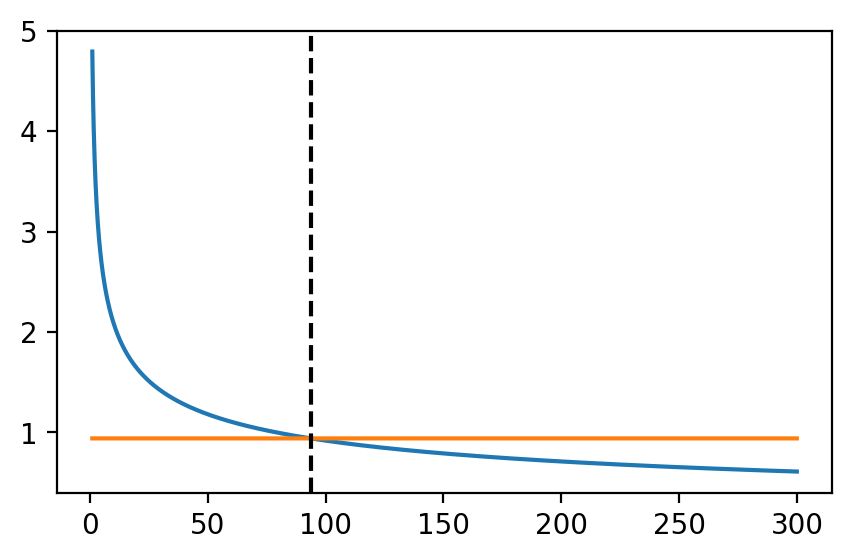

In [11]:
rel_range_data = df_mean.loc[df_mean['Condition']=='B']['rel_range'].values[0] 

c_up_P = np.arange(1,300.1,0.1)
#option 0: no other fits
community_B0 = community(rho=fit_pars_0['rho'], lPro=fit_pars_0['lPro'], lTrp=fit_pars_0['lTrp'], mu_WT=growth_rates['WT'], mu_dT=growth_rates['dT'], mu_dP=growth_rates['dP_proUp'], c_up_P=c_up_P)
#option 1: fit rho
community_B1 = community(rho=fit_pars_1['rho'], lPro=fit_pars_1['lPro'], lTrp=fit_pars_1['lTrp'], mu_WT=growth_rates['WT'], mu_dT=growth_rates['dT'], mu_dP=growth_rates['dP_proUp'], c_up_P=c_up_P)
#option 2: fit rho and leakage
community_B2 = community(rho=fit_pars_2['rho'], lPro=fit_pars_2['lPro'], lTrp=fit_pars_2['lTrp'], mu_WT=growth_rates['WT'], mu_dT=growth_rates['dT'], mu_dP=growth_rates['dP_proUp'], c_up_P=c_up_P)
#option 3: fit leakage
community_B3 = community(rho=fit_pars_3['rho'], lPro=fit_pars_3['lPro'], lTrp=fit_pars_3['lTrp'], mu_WT=growth_rates['WT'], mu_dT=growth_rates['dT'], mu_dP=growth_rates['dP_proUp'], c_up_P=c_up_P)

y0 = community_B0.rangeP / community_B0.rangeT
y1 = community_B1.rangeP / community_B1.rangeT
y2 = community_B2.rangeP / community_B2.rangeT
y3 = community_B3.rangeP / community_B3.rangeT

c_up0, idx0 = fit_1D(c_up_P, rel_range_data, y0)
c_up1, idx1 = fit_1D(c_up_P, rel_range_data, y1)
c_up2, idx2 = fit_1D(c_up_P, rel_range_data, y2)
c_up3, idx3 = fit_1D(c_up_P, rel_range_data, y3)

print(f"c_up_P = {c_up0:.2f} (no fit) || {c_up1:.2f} (rho fit) || {c_up2:.2f} (rho + leakage fit) || {c_up3:.2f} (leakage fit)")
print(f"eqFrac = {community_B0.eq[idx0]:.2f} (no fit) || {community_B1.eq[idx1]:.2f} (rho fit) || {community_B2.eq[idx2]:.2f} (rho + leakage fit) || {community_B3.eq[idx3]:.2f} (leakage fit)")
print(f"sec_dP = {community_B0.rangeP[idx0]:.2f} (no fit) || {community_B1.rangeP[idx1]:.2f} (rho fit) || {community_B2.rangeP[idx2]:.2f} (rho + leakage fit) || {community_B3.rangeP[idx3]:.2f} (leakage fit)")
print(f"sec_PT = {community_B0.rangeP[idx0]/community_B0.rangeT:.2f} (no fit) || {community_B1.rangeP[idx1]/community_B1.rangeT:.2f} (rho fit) || {community_B2.rangeP[idx2]/community_B2.rangeT:.2f} (rho + leakage fit) || {community_B3.rangeP[idx3]/community_B3.rangeT:.2f} (leakage fit)")

report_data(df, 'B')


----

## Characterize trpR using community C

Fit trpR  increase in trp release for community C based on equilibrium frequency data

c_prod_T_P = nan (no fit) || nan (rho fit) || 50.30 (rho + leakage fit) || 40.00 (leakage fit)
eqFrac = 0.50 (no fit) || 0.50 (rho fit) || 0.59 (rho + leakage fit) || 0.59 (leakage fit)
relmu = 0.42 (no fit) || 0.43 (rho fit) || 0.23 (rho + leakage fit) || 0.23 (leakage fit)
Experiments: CC: f(dT) = 0.59, rel. growth = -0.00, sectors dP = 19.25um, sectors dT = 8.28um, sector ratio = 2.40


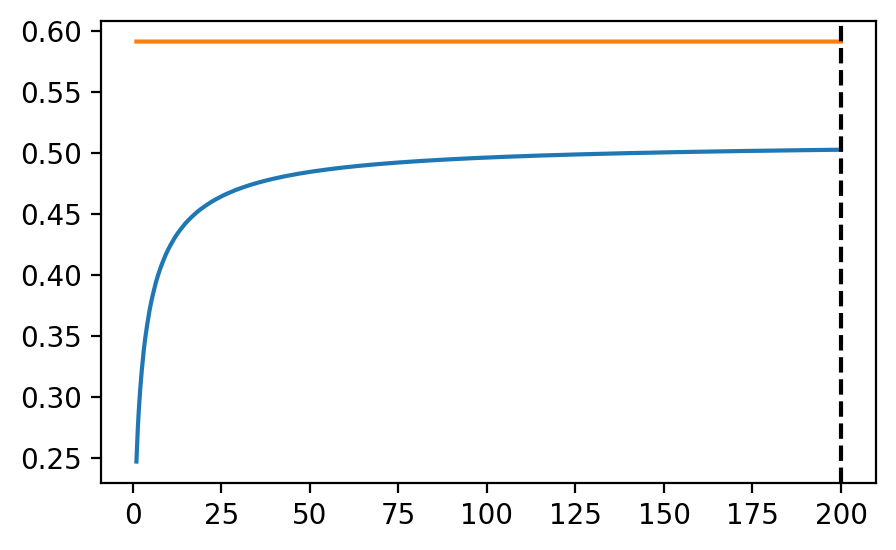

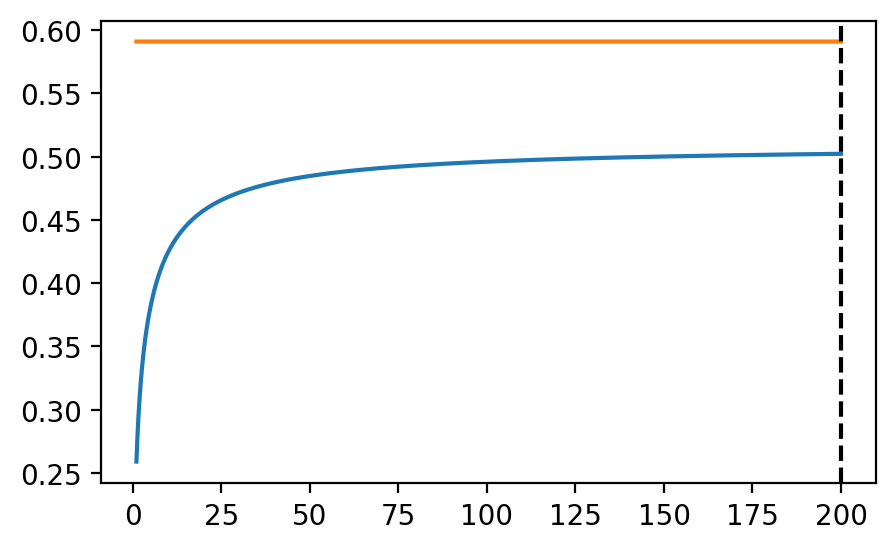

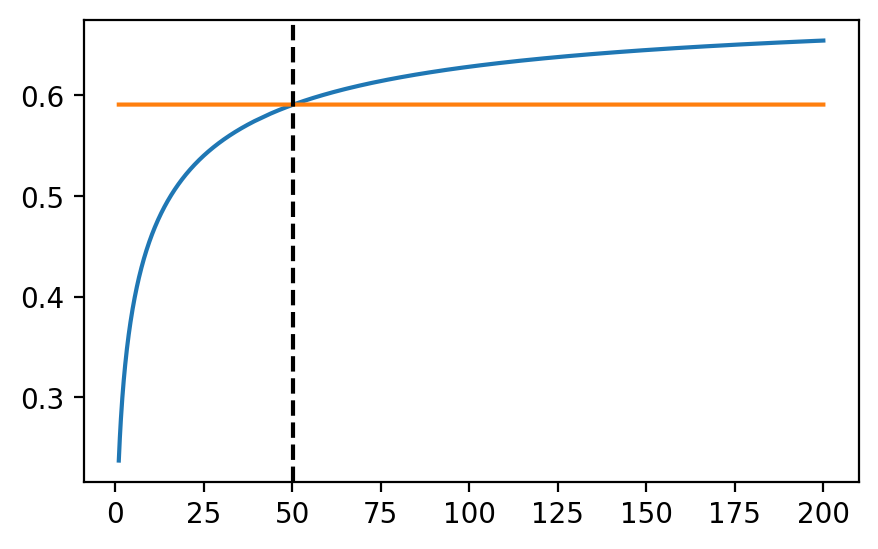

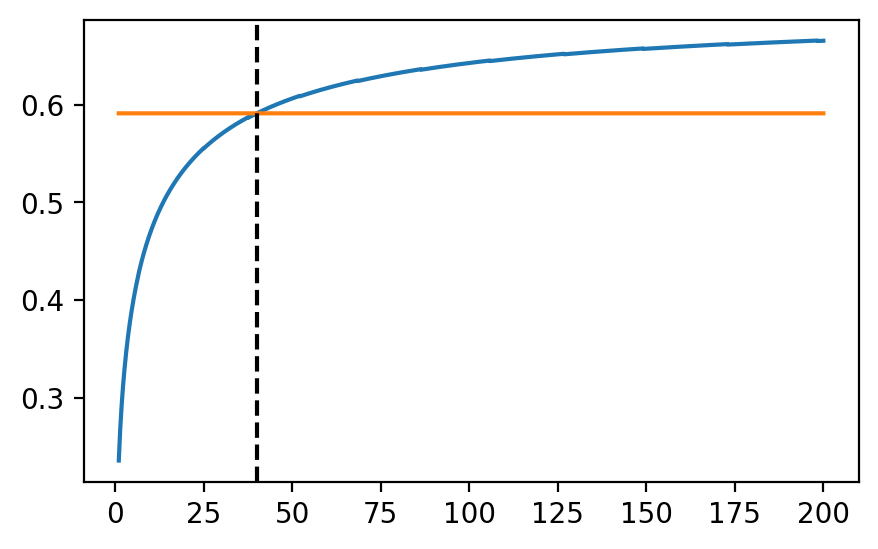

In [12]:
#get measured value
eq_data = df_mean.loc[df_mean['Condition']=='C']['Ratio'].values[0]

#calc model predictions with varying cost for putP
c_prod_T = np.arange(1,200.1,0.1)

#option 0: no other fits
community_C0 = community(rho=fit_pars_0['rho'], lPro=fit_pars_0['lPro'], lTrp=fit_pars_0['lTrp'], mu_WT=growth_rates['WT'], mu_dT=growth_rates['dT'], mu_dP=growth_rates['dP_trpOP'], c_prod_T=c_prod_T)
#option 1: fit rho
community_C1 = community(rho=fit_pars_1['rho'], lPro=fit_pars_1['lPro'], lTrp=fit_pars_1['lTrp'], mu_WT=growth_rates['WT'], mu_dT=growth_rates['dT'], mu_dP=growth_rates['dP_trpOP'], c_prod_T=c_prod_T)
#option 2: fit rho and leakage
community_C2 = community(rho=fit_pars_2['rho'], lPro=fit_pars_2['lPro'], lTrp=fit_pars_2['lTrp'], mu_WT=growth_rates['WT'], mu_dT=growth_rates['dT'], mu_dP=growth_rates['dP_trpOP'], c_prod_T=c_prod_T)
#option 3: fit leakage
community_C3 = community(rho=fit_pars_3['rho'], lPro=fit_pars_3['lPro'], lTrp=fit_pars_3['lTrp'], mu_WT=growth_rates['WT'], mu_dT=growth_rates['dT'], mu_dP=growth_rates['dP_trpOP'], c_prod_T=c_prod_T)

y0 = community_C0.eq
y1 = community_C1.eq
y2 = community_C2.eq
y3 = community_C3.eq

c_prod_T0, idx0 = fit_1D(c_prod_T, eq_data, y0)
c_prod_T1, idx1 = fit_1D(c_prod_T, eq_data, y1)
c_prod_T2, idx2 = fit_1D(c_prod_T, eq_data, y2)
c_prod_T3, idx3 = fit_1D(c_prod_T, eq_data, y3)

print(f"c_prod_T_P = {c_prod_T0:.2f} (no fit) || {c_prod_T1:.2f} (rho fit) || {c_prod_T2:.2f} (rho + leakage fit) || {c_prod_T3:.2f} (leakage fit)")
print(f"eqFrac = {community_C0.eq[idx0]:.2f} (no fit) || {community_C1.eq[idx1]:.2f} (rho fit) || {community_C2.eq[idx2]:.2f} (rho + leakage fit) || {community_C3.eq[idx3]:.2f} (leakage fit)")
print(f"relmu = {community_C0.rel_growth_wt[idx0]:.2f} (no fit) || {community_C1.rel_growth_wt[idx1]:.2f} (rho fit) || {community_C2.rel_growth_wt[idx2]:.2f} (rho + leakage fit) || {community_C3.rel_growth_wt[idx3]:.2f} (leakage fit)")

report_data(df, 'C')

fit_pars_0['c_prod_T'] = c_prod_T0 
fit_pars_1['c_prod_T'] = c_prod_T1 
fit_pars_2['c_prod_T'] = c_prod_T2 
fit_pars_3['c_prod_T'] = c_prod_T3 

----

## Characterize proB74 using community E

Fit proB74 increase in pro release for community E based on EQ data


c_prod_P = nan (no fit) || nan (rho fit) || 5.20 (rho + leakage fit) || 5.00 (leakage fit)
eqFrac = 0.27 (no fit) || 0.28 (rho fit) || 0.19 (rho + leakage fit) || 0.19 (leakage fit)
relmu = 0.24 (no fit) || 0.25 (rho fit) || 0.12 (rho + leakage fit) || 0.11 (leakage fit)
Experiments: CE: f(dT) = 0.19, rel. growth = 0.74, sectors dP = 491.05um, sectors dT = 119.57um, sector ratio = 4.07


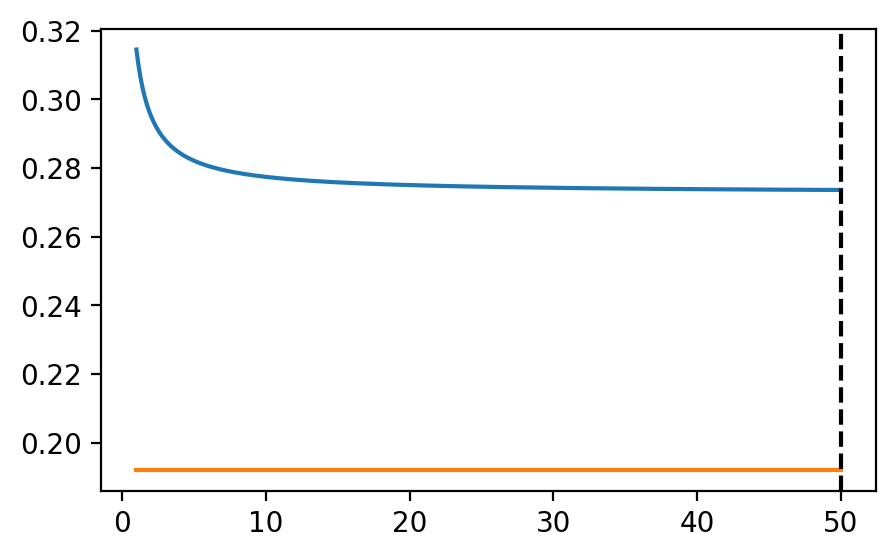

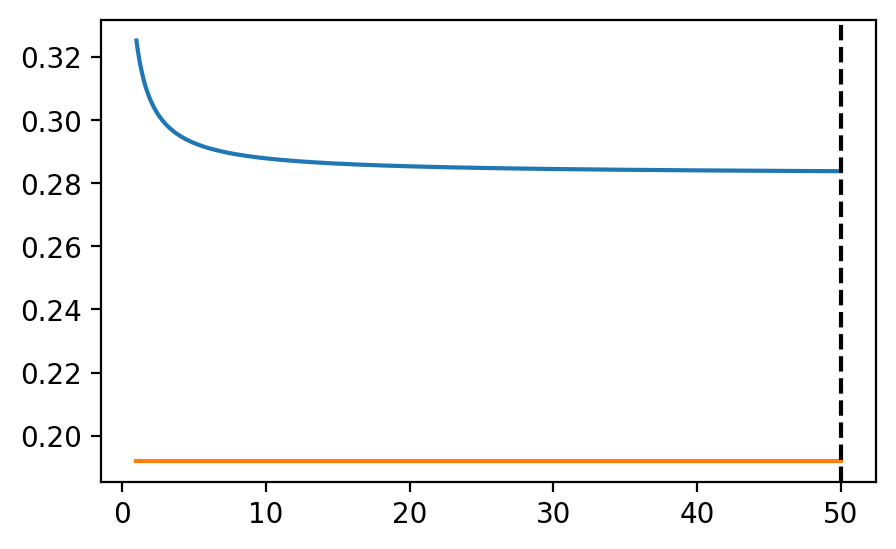

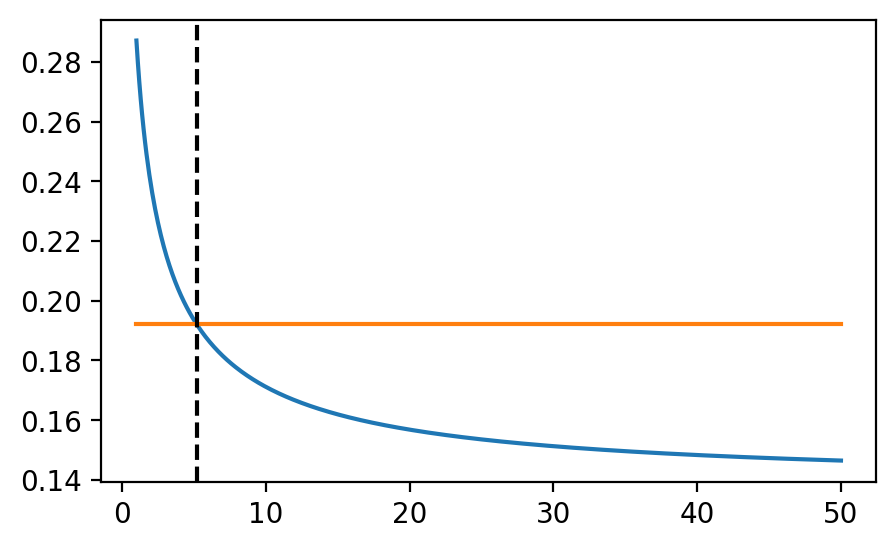

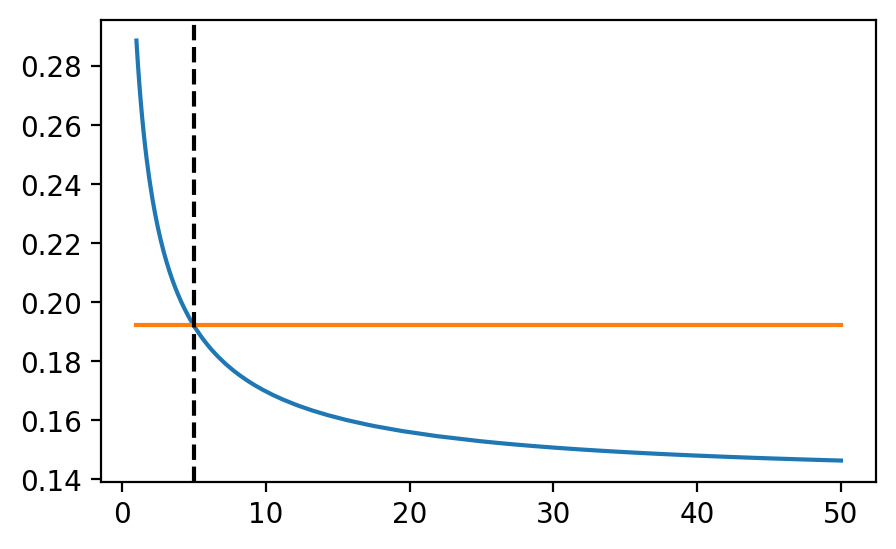

In [13]:
#get measured value
eq_data = df_mean.loc[df_mean['Condition']=='E']['Ratio'].values[0]

#calc model predictions with varying cost for putP
c_prod_P = np.arange(1,50.1,0.1)

#option 0: no other fits
community_E0 = community(rho=fit_pars_0['rho'], lPro=fit_pars_0['lPro'], lTrp=fit_pars_0['lTrp'], mu_WT=growth_rates['WT'], mu_dT=growth_rates['dT_proOP'], mu_dP=growth_rates['dP'], c_prod_P=c_prod_P)
#option 1: fit rho
community_E1 = community(rho=fit_pars_1['rho'], lPro=fit_pars_1['lPro'], lTrp=fit_pars_1['lTrp'], mu_WT=growth_rates['WT'], mu_dT=growth_rates['dT_proOP'], mu_dP=growth_rates['dP'], c_prod_P=c_prod_P)
#option 2: fit rho and leakage
community_E2 = community(rho=fit_pars_2['rho'], lPro=fit_pars_2['lPro'], lTrp=fit_pars_2['lTrp'], mu_WT=growth_rates['WT'], mu_dT=growth_rates['dT_proOP'], mu_dP=growth_rates['dP'], c_prod_P=c_prod_P)
#option 3: fit leakage
community_E3 = community(rho=fit_pars_3['rho'], lPro=fit_pars_3['lPro'], lTrp=fit_pars_3['lTrp'], mu_WT=growth_rates['WT'], mu_dT=growth_rates['dT_proOP'], mu_dP=growth_rates['dP'], c_prod_P=c_prod_P)

y0 = community_E0.eq
y1 = community_E1.eq
y2 = community_E2.eq
y3 = community_E3.eq

c_prod_P0, idx0 = fit_1D(c_prod_P, eq_data, y0)
c_prod_P1, idx1 = fit_1D(c_prod_P, eq_data, y1)
c_prod_P2, idx2 = fit_1D(c_prod_P, eq_data, y2)
c_prod_P3, idx3 = fit_1D(c_prod_P, eq_data, y3)

print(f"c_prod_P = {c_prod_P0:.2f} (no fit) || {c_prod_P1:.2f} (rho fit) || {c_prod_P2:.2f} (rho + leakage fit) || {c_prod_P3:.2f} (leakage fit)")
print(f"eqFrac = {community_E0.eq[idx0]:.2f} (no fit) || {community_E1.eq[idx1]:.2f} (rho fit) || {community_E2.eq[idx2]:.2f} (rho + leakage fit) || {community_E3.eq[idx3]:.2f} (leakage fit)")
print(f"relmu = {community_E0.rel_growth_wt[idx0]:.2f} (no fit) || {community_E1.rel_growth_wt[idx1]:.2f} (rho fit) || {community_E2.rel_growth_wt[idx2]:.2f} (rho + leakage fit) || {community_E3.rel_growth_wt[idx3]:.2f} (leakage fit)")

report_data(df, 'E')

fit_pars_0['c_prod_P'] = c_prod_P0 
fit_pars_1['c_prod_P'] = c_prod_P1 
fit_pars_2['c_prod_P'] = c_prod_P2 
fit_pars_3['c_prod_P'] = c_prod_P3 

---

## Report fitting results

In [14]:
print(fit_pars_2)
print(fit_pars_3)

{'rho': 0.30000000000000004, 'lPro': 9.20373199661823e-07, 'lTrp': 7.90492762269642e-08, 'c_up_P': 6.100000000000005, 'c_prod_T': 50.30000000000005, 'c_prod_P': 5.200000000000004}
{'rho': 0.65, 'lPro': 9.593608287093148e-07, 'lTrp': 9.5275004724273e-08, 'c_up_P': 6.100000000000005, 'c_prod_T': 40.000000000000036, 'c_prod_P': 5.0000000000000036}


---
## Define prediction function

In [17]:
def predict_community_prop(fit_pars_loc): 
    par_com_A = {'rho': fit_pars_loc['rho'], 
                'lPro': fit_pars_loc['lPro'], 
                'lTrp': fit_pars_loc['lTrp'], 
                'c_prod_T': 1, 
                'c_prod_P': 1,
                'c_up_P': 1,
                'mu_dP': growth_rates['dP'],
                'mu_dT': growth_rates['dT'],
                }

    par_com_B = {'rho': fit_pars_loc['rho'], 
                'lPro': fit_pars_loc['lPro'], 
                'lTrp': fit_pars_loc['lTrp'], 
                'c_prod_T': 1, 
                'c_prod_P': 1,
                'c_up_P': fit_pars_loc['c_up_P'],
                'mu_dP': growth_rates['dP_proUp'],
                'mu_dT': growth_rates['dT'],
                }

    par_com_C = {'rho': fit_pars_loc['rho'], 
                'lPro': fit_pars_loc['lPro'], 
                'lTrp': fit_pars_loc['lTrp'], 
                'c_prod_T': fit_pars_loc['c_prod_T'], 
                'c_prod_P': 1,
                'c_up_P': 1,
                'mu_dP': growth_rates['dP_trpOP'],
                'mu_dT': growth_rates['dT'],
                }

    par_com_D = {'rho': fit_pars_loc['rho'], 
                'lPro': fit_pars_loc['lPro'], 
                'lTrp': fit_pars_loc['lTrp'], 
                'c_prod_T': fit_pars_loc['c_prod_T'], 
                'c_prod_P': 1,
                'c_up_P': fit_pars_loc['c_up_P'],
                'mu_dP': growth_rates['dP_proUp'], #need to be measured
                'mu_dT': growth_rates['dT'],
                }

    par_com_E = {'rho': fit_pars_loc['rho'], 
                'lPro': fit_pars_loc['lPro'], 
                'lTrp': fit_pars_loc['lTrp'], 
                'c_prod_T': 1, 
                'c_prod_P': fit_pars_loc['c_prod_P'],
                'c_up_P': 1,
                'mu_dP': growth_rates['dP'],
                'mu_dT': growth_rates['dT_proOP'],
                }

    par_com_F = {'rho': fit_pars_loc['rho'], 
                'lPro': fit_pars_loc['lPro'], 
                'lTrp': fit_pars_loc['lTrp'], 
                'c_prod_T': 1, 
                'c_prod_P': fit_pars_loc['c_prod_P'],
                'c_up_P': fit_pars_loc['c_up_P'],
                'mu_dP': growth_rates['dP_proUp'], 
                'mu_dT': growth_rates['dT_proOP'],
                }


    par_com_G = {'rho': fit_pars_loc['rho'], 
                'lPro': fit_pars_loc['lPro'], 
                'lTrp': fit_pars_loc['lTrp'], 
                'c_prod_T': fit_pars_loc['c_prod_T'], 
                'c_prod_P': fit_pars_loc['c_prod_P'],
                'c_up_P': 1,
                'mu_dP': growth_rates['dP_trpOP'],
                'mu_dT': growth_rates['dT_proOP'],
                }

    par_com_H = {'rho': fit_pars_loc['rho'], 
                'lPro': fit_pars_loc['lPro'], 
                'lTrp': fit_pars_loc['lTrp'], 
                'c_prod_T': fit_pars_loc['c_up_P'], 
                'c_prod_P': fit_pars_loc['c_prod_P'],
                'c_up_P': fit_pars_loc['c_up_P'],
                'mu_dP': growth_rates['dP_proUp'], #needs to be measured
                'mu_dT': growth_rates['dT_proOP'],
                }


    par_coms = {'A': par_com_A, 'B': par_com_B, 'C': par_com_C, 'D': par_com_D, 'E': par_com_E, 'F': par_com_F, 'G': par_com_G, 'H': par_com_H}    

    communities = {key: community(mu_WT=growth_rates['WT'], **val) for key, val in par_coms.items()}


    df_pred = pd.DataFrame()
    for key, val in communities.items():
        df_pred.loc[key, 'community'] = key
        df_pred.loc[key, 'source'] = 'prediction'
        df_pred.loc[key, 'eq freq'] = val.eq
        df_pred.loc[key, 'relative growth'] = val.rel_growth_wt
        df_pred.loc[key, 'relative range'] = val.rangeP/val.rangeT
        df_pred.loc[key, 'range dP'] = val.rangeP
        df_pred.loc[key, 'range dT'] = val.rangeT
        
    columns_data={'Condition': 'community', 'Ratio': 'eq freq', 'rel_growth': 'relative growth', 'rel_range': 'relative range', 'dT_patch': 'range dT', 'dP_patch': 'range dP'}
    df_data = df_mean.copy()
    df_data = df_data.rename(columns=columns_data)
    df_data['relative growth'] = df_data['Width'] / df_data.loc[df_data['community']=='WT']['Width'].values[0]
    df_data = df_data[df_data['community'] != 'WT'].reset_index(drop=True)
    df_data['source'] = 'data'
    df_data.drop('Width',axis=1,inplace=True)    

    return pd.concat([df_data, df_pred]).reset_index(drop=True)

def plot_predictions(df, name):
    fig, axs = plt.subplots(2,3,figsize=(10,6))

    sns.barplot(df, x="community", y="eq freq", hue="source", ax=axs[0][0])
    sns.barplot(df, x="community", y="relative range", hue="source", ax=axs[0][1])
    sns.barplot(df, x="community", y="relative growth", hue="source", ax=axs[0][2])

    sns.barplot(df, x="community", y="range dT", hue="source", ax=axs[1][0])
    sns.barplot(df, x="community", y="range dP", hue="source", ax=axs[1][1])
    fig.tight_layout()

    # Set max y-axis value for each subplot
    axs[0][0].set_ylim(top=1)  # Set max y-axis value for the first subplot
    axs[0][1].set_ylim(top=6)  # Set max y-axis value for the third subplot
    axs[0][2].set_ylim(top=1)  # Set max y-axis value for the second subplot

    axs[1][0].set_ylim(top=40)  # Set max y-axis value for the fourth subplot
    axs[1][1].set_ylim(top=80)  # Set max y-axis value for the fifth subplot

    #add text in axs[1][1]
    axs[1][2].text(0,0.5, f"{name:s}", color='k', fontsize=10)
    axs[0][0].axhline(y=0.5, color='k', linestyle='--')
    axs[0][1].axhline(y=0.5, color='k', linestyle='--')
    fig.savefig(f"{name:s}.pdf")
    
    return None

---

## Predict community properties

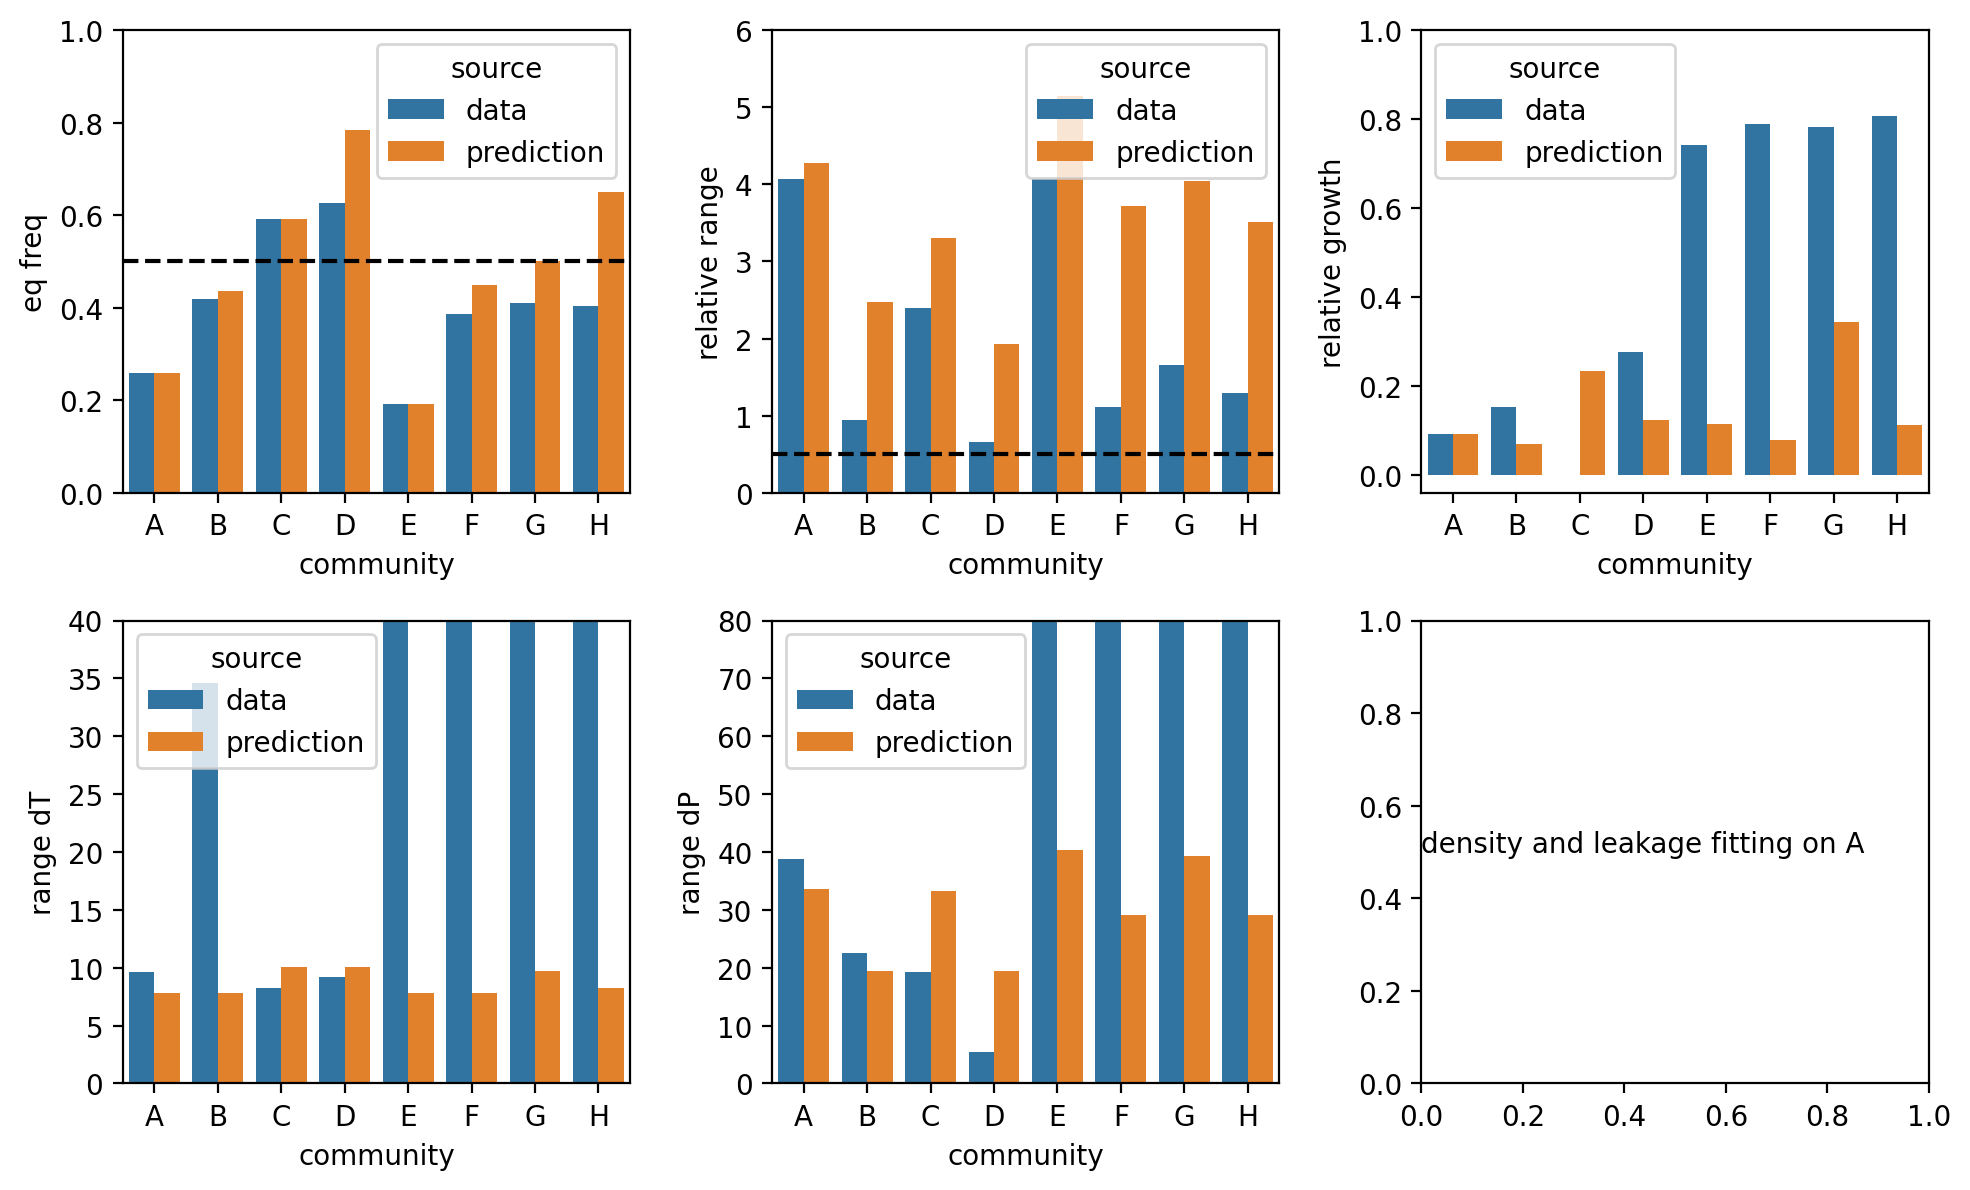

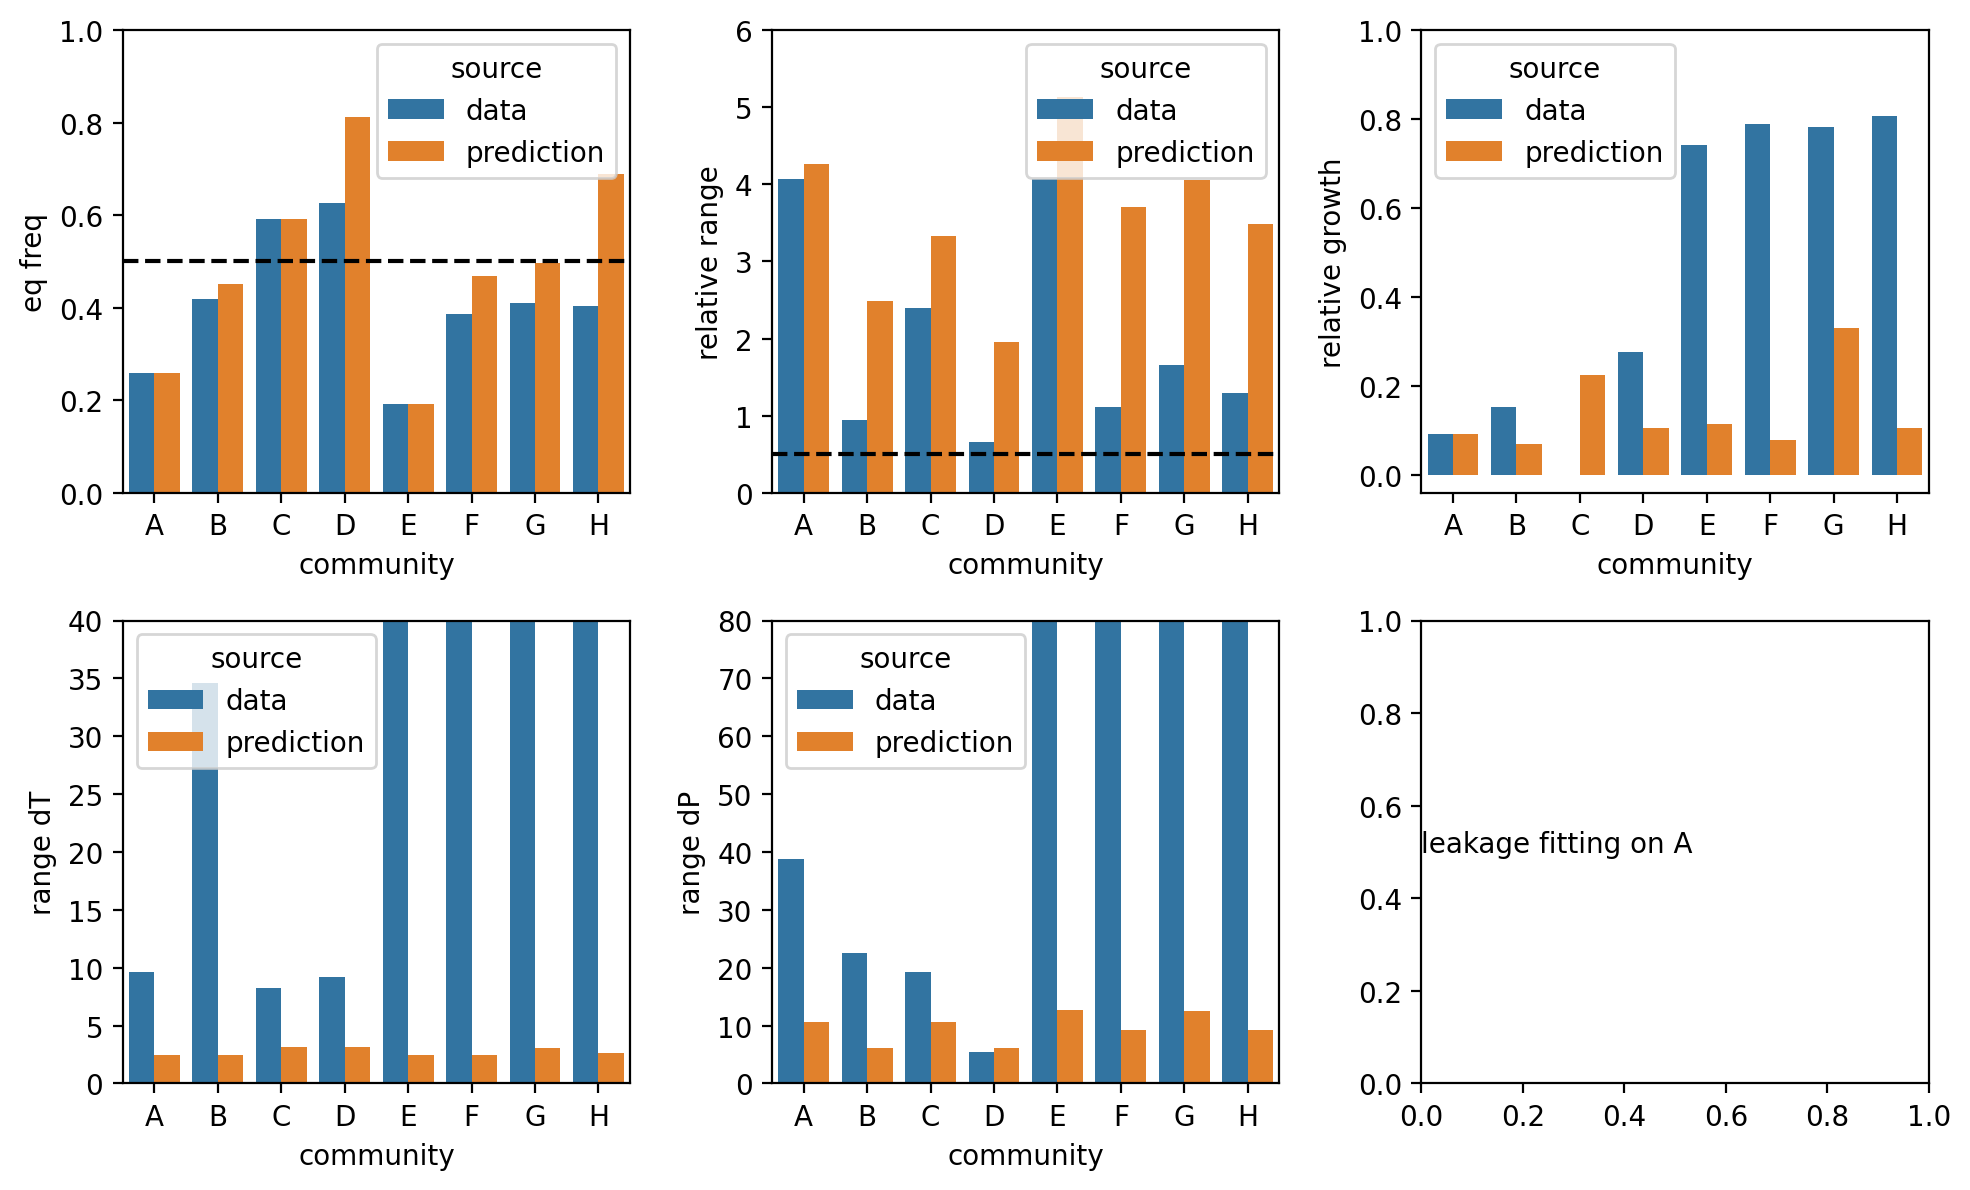

In [18]:
fit_par_list = [fit_pars_2, fit_pars_3]
fit_par_name = ['density and leakage fitting on A','leakage fitting on A']
df_list = [predict_community_prop(fit_pars) for fit_pars in fit_par_list]

for df, name in zip(df_list, fit_par_name):
    plot_predictions(df, name)